In [18]:
import numpy as np
import os 
import gc
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize

input_path = '../Kaggle_competitions/'
train_path = os.path.join(input_path, "color_sep/train")
train_masks = os.path.join(input_path, "Carvana Image Masking/train_masks")

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv
# using cpu
ctx = mx.cpu(0)

In [19]:
train_masks

'../Kaggle_competitions/Carvana Image Masking/train_masks'

In [20]:
import gc
gc.collect()

2206

In [37]:
folder = "white"
item = "2c57132da7a0_04.jpg"

In [38]:
img = image.imresize(image.imread(train_path + '/' + folder + '/' + item), 300, 300)

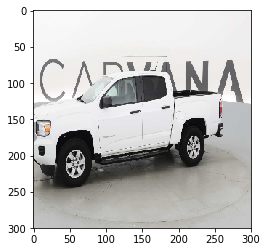

In [39]:
plt.imshow(img.asnumpy())

In [40]:
from gluoncv.data.transforms.presets.segmentation import test_transform
img = test_transform(img, ctx)

In [41]:
model = gluoncv.model_zoo.get_model('psp_resnet101_ade', pretrained=True)

self.crop_size 480


In [48]:
output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

In [52]:
np.unique(predict)

array([  0.,   2.,   3.,   6.,  16.,  20., 102.], dtype=float32)

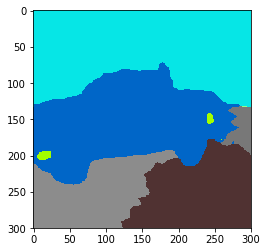

In [49]:
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg
mask = get_color_pallete(predict, 'ade20k')
mask.save('output.png')

mmask = mpimg.imread('output.png')
plt.imshow(mmask)
plt.show()

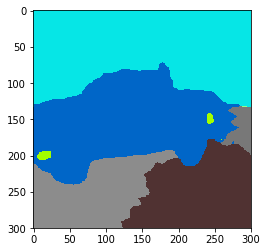

In [50]:
plt.imshow(mmask)

In [17]:
predict

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

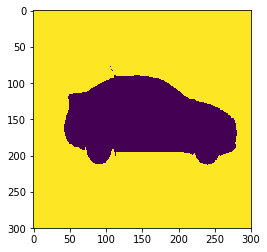

In [10]:
plt.imshow(mask[:,:,0] == 0)

In [11]:
im = img[~(mask[:,:,0]  == 0)]

In [12]:
import colorsys

print(im[0])
print(list(colorsys.rgb_to_hsv(im[0][0], im[0][1], im[0][2])))

[0.65413072 0.65413072 0.6510719 ]
[0.16666666666666666, 0.004676165544258788, 0.6541307189540878]


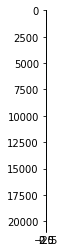

In [13]:
plt.imshow(im)

In [14]:
im_hsv = np.array([list(colorsys.rgb_to_hsv(item[0], item[1], item[2])) for item in im])
im_hsv

array([[0.16666667, 0.00467617, 0.65413072],
       [0.19444444, 0.03157175, 0.74526797],
       [0.19444444, 0.07108584, 0.331     ],
       ...,
       [0.        , 0.        , 0.09292157],
       [0.        , 0.        , 0.11764706],
       [0.        , 0.        , 0.11764706]])

In [15]:
from clusters import Cluster
from back import Back
from selector import Selector
from color_detect import ColorDetector

In [16]:
cl = Cluster()
result = cl.clusterize(im_hsv)
print("centroides encontradas: ")
print(result)
print('\n')


sl = Selector()
cent = np.array(sl.largest(result[0], result[1], result[2])[0])
print("centroide escolhida: ")
print(cent)
print("centroide em rgb: ")
rgb_cent = list(colorsys.hsv_to_rgb(cent[0][0], cent[0][1], cent[0][2]))
print(rgb_cent)
print('\n')


det = ColorDetector()
c = det.color_of(rgb_cent)
        
print("Color of vehicle: " + c)

centroides encontradas: 
(6, array([2, 2, 1, ..., 1, 1, 1]), array([[0.60230794, 0.9074353 , 0.77147521],
       [0.029202  , 0.04464209, 0.17513859],
       [0.48375417, 0.07803514, 0.78420319],
       [0.57425634, 0.13350554, 0.3777391 ],
       [0.59465888, 0.70421824, 0.95380718],
       [0.60131909, 0.88559986, 0.42194333]]))


centroide escolhida: 
[[0.59465888 0.70421824 0.95380718]]
centroide em rgb: 
[0.28211876188050117, 0.5723195317129632, 0.953807180088998]


Color of vehicle: black


In [17]:
import cv2

In [18]:
np.arange(0, len(np.unique(result[1])))

array([0, 1, 2, 3, 4, 5])

In [19]:
unique, counts = np.unique(result[1], return_counts=True)

In [20]:
np.argsort(counts)

array([5, 2, 1, 3, 0, 4], dtype=int64)

In [21]:
numLabels = np.arange(0, len(np.unique(result[1]))) 
(hist, _) = np.histogram(result[1], bins = numLabels)

In [22]:
hist = hist.astype("float")

In [23]:
hist

array([5243., 2295., 1822., 3447., 7816.])

In [24]:
hist /= hist.sum()

In [25]:
hist

array([0.25423071, 0.11128352, 0.08834796, 0.16714348, 0.37899433])

In [40]:
# initialize the bar chart representing the relative frequency
# of each of the colors
bar = np.zeros((50, 300, 3), dtype = "uint8")
startX = 0

# loop over the percentage of each cluster and the color of
# each cluster
for (percent, color) in zip(hist, result[2]):
	# plot the relative percentage of each cluster
	endX = startX + (percent * 300)
	cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
		color.astype("uint8").tolist(), -1)
	startX = endX

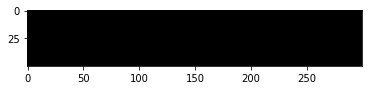

In [41]:
plt.imshow(bar)

In [112]:
for (percent, color) in zip(hist, result[2]):
    print(percent)
    print(color)

0.17722930708432333
[150.67915972 157.93400322 162.15891494]
0.29054938660718616
[ 18.88215372  85.43173738 191.27784318]
0.5322213063084905
[40.1069232  46.83527128 59.04630091]
